In this notebook, we track with higher precision how the eddy water changes with year.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sets import Set
import calendar
import seaborn as sns
import csvWOD
import falkor_ctd
import copy
import seawater as SW
import os
from mpl_toolkits.basemap import Basemap

# switch to unbuffered output
# we create a class that overrides the write function of a stream object
# in this write function, we call the super write, then we also flush
# the stream -- this has the effect of forcing output to the screen after 
# every write
class Unbuffered(object):
    def __init__(self, stream):
        self.stream = stream
    def write(self, data):
        self.stream.write(data)
        self.stream.flush()
    def __getattr__(self, attr):
        return getattr(self.stream, attr)

import sys
sys.stdout = Unbuffered(sys.stdout)

sns.set()
sns.set_style("darkgrid")
sns.set_context("poster")

%matplotlib inline

We need a function to convert Falkor CTD data to the format used in csvWOD reader.

In [2]:
def conv_falkor_to_csvWOD(thedata,index,station,latitude,longitude):
    ret_dat = {}
    
    ret_dat['Station'] = station
    ret_dat['Latitude'] = latitude
    ret_dat['Longitude'] = longitude
    ret_dat['Temperatur'] = list(thedata[index['Temperature']])
    ret_dat['Salinity'] = list(thedata[index['Salinity']])
    ret_dat['Oxygen'] = list(thedata[index['Oxygen']])
    #ret_dat['Fluorescence'] = list(thedata[index['Fluorescence']])
    #ret_dat['Turbidity'] = list(thedata[index['Turbidity']])
    ret_dat['Year'] = 2013
    ret_dat['Month'] = 8
    ret_dat['Units'] = ['degrees C','psu','g/kg','m']#,'','']
    ret_dat['Variables'] = ['Temperatur','Salinity','Oxygen','Depth']#,'Fluorescence','Turbidity']
    
    # convert from pressure to depth
    p = thedata[index['Pressure']]
    d = []
    for ii in p:
        d.append(SW.dpth(ii,latitude))
    
    ret_dat['Depth'] = list(d)
    
    return ret_dat

In [3]:
def load_falkor_dat():
    filenames = [f for f in os.listdir(falkor_ctd.DIRECTORY) if (f.startswith('2013-57-00') and f.endswith('avg'))]

    all_casts = []
    for count,filename in enumerate(sorted(filenames)):
        thedata,index,station,lat,lon = falkor_ctd.falkor_ctd_dat(filename)
                
        latitude = float(lat.split(' ')[1]) + float(lat.split(' ')[3])/60.0
        longitude = -(float(lon.split(' ')[0]) + float(lon.split(' ')[2])/60.0)
        
        all_casts.append(conv_falkor_to_csvWOD(thedata,index,station,latitude,longitude))
        
    return all_casts
    
def load_NOAA_dat():
    cast_inf = []

    FILES = ['../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD.csv',
             '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD2.csv',
             '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD3.csv',
             '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD4.csv',
             '../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD5.csv'
             #'../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.OSD.csv'
            ]

    for fn in FILES:
        print '-----------------------------------------------------------------'
        print fn
        print '-----------------------------------------------------------------'
        print '> Parsing'
        tmp_casts = []
        tmp_casts = csvWOD.read_casts(fn)
        print '> Done parsing'
        print '> Regionally filtering' # likely don't need this filter 
        tmp_casts = csvWOD.filter_region(tmp_casts,-160,-120,15,60)
        tmp_casts = csvWOD.filter_variables(tmp_casts,['Temperatur','Salinity','Depth'])
        print '> Done filtering'
        print '> Appending new casts'
        cast_inf.extend(tmp_casts)
        print '> Done' 
        print ''

    print 'Total casts: ', len(cast_inf)
    return cast_inf

In [4]:
def load_all_data():
    print '========================================='
    print ''
    print '            LOADING NOAA DATA'
    print ''
    print '========================================='
    
    NOAA_CAST = load_NOAA_dat()
    
    print '========================================='
    print ''
    print '            LOADING FALKOR DATA'
    print ''
    print '========================================='
    
    FALKOR_CAST = load_falkor_dat()
    
    print 'DONE'
    NOAA_CAST.extend(FALKOR_CAST)
    
    cast_inf = copy.copy(NOAA_CAST)    
    return cast_inf

In [5]:
cast_inf = load_all_data()


            LOADING NOAA DATA

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD2.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb1432579402.10924.CTD3.csv
-----------------------------------------------------------------
> Parsing
> Done parsing
> Regionally filtering
> Done filtering
> Appending new casts
> Done

-----------------------------------------------------------------
../../5_WOD13_Data/WOD13_004/ocldb14325794

We want to focus in on the Juan de Fuca eddy region and evaluate the dominant water properties -- both as a function of month, and of year.

In [248]:
#ER_lon = [-125.5,-124.75]
#ER_lat = [48.3,48.7]

ER_lon = [-125.5,-124.8]
ER_lat = [48.2,48.7]

# ER_x and ER_y used for plotting
ER_x = [ER_lon[0],ER_lon[1],ER_lon[1],ER_lon[0],ER_lon[0]]
ER_y = [ER_lat[0],ER_lat[0],ER_lat[1],ER_lat[1],ER_lat[0]]

ER_cast_inf = csvWOD.filter_region(cast_inf,ER_lon[0],ER_lon[1],ER_lat[0],ER_lat[1])

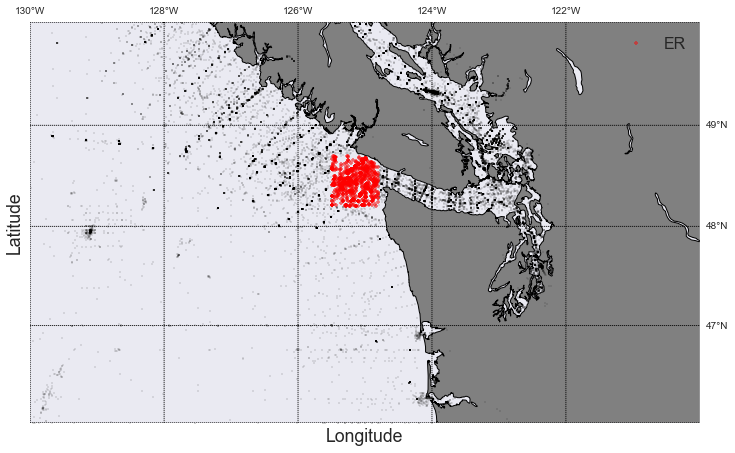

In [249]:
plt.figure(figsize=(12,12))

sns.set_style("darkgrid")
sns.set_context("poster")

b_map = Basemap(projection='merc',llcrnrlat=46,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-120,lat_ts=20,resolution='h')

x_all, y_all = b_map([k['Longitude'] for k in cast_inf],[k['Latitude'] for k in cast_inf])
b_map.plot(x_all,y_all,'.k',ms=2,alpha=0.5)

x_ER, y_ER = b_map([k['Longitude'] for k in ER_cast_inf],[k['Latitude'] for k in ER_cast_inf])
b_map.plot(x_ER,y_ER,'.r',ms=8,label='ER',alpha=.5)

b_map.drawcoastlines()
b_map.fillcontinents(color=[0.5,0.5,0.5],lake_color=None)

# meridians on bottom and left
parallels = np.arange(40.,60,2.)
# labels = [left,right,top,bottom]
b_map.drawparallels(np.arange(40,60,1),labels=[False,True,True,False])
b_map.drawmeridians(np.arange(-130,-120,2),labels=[False,True,True,False])

#plt.ylim((46,50))
#plt.xlim((-130,-120))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

Okay so we have all casts in the eddy region for all years and all months. Let's start by looking at how the dominant water features change in time. This is done by looking at the T-S histogram data and choosing the mode T-S cell.

In [250]:
def get_TS_hist(casts,Sbins,Tbins):
    Tlist = [y for x in casts for y in x['Temperatur']]
    Slist = [y for x in casts for y in x['Salinity']]
           
    hist = np.histogram2d(Slist,Tlist,bins=[Sbins,Tbins])[0]
    return hist

def get_mode_ind(hist):
    IND = np.unravel_index(hist.argmax(), hist.shape)
    return IND

def get_bin_dat(casts,SbinL,SbinR,TbinL,TbinR):
    match_dat = {'Temperatur' : [], 'Salinity' : [], 'Depth' : [], 'Pressure' : [], 'sigmaT' : []}
    for cast in casts:
        for ii in range(0,len(cast['Depth'])):
            if cast['Temperatur'][ii] >= TbinL and cast['Temperatur'][ii] < TbinR \
               and cast['Salinity'][ii] >= SbinL and cast['Salinity'][ii] < SbinR:
                # we have a cast that belongs
                match_dat['Temperatur'].append(cast['Temperatur'][ii])
                match_dat['Salinity'].append(cast['Salinity'][ii])
                match_dat['Depth'].append(cast['Depth'][ii])
                match_dat['Pressure'].append(SW.pres(cast['Depth'][ii],cast['Latitude']))
                match_dat['sigmaT'].append(SW.dens(cast['Salinity'][ii],cast['Temperatur'][ii],SW.pres(cast['Depth'][ii],cast['Latitude']))-1000.0)
    return match_dat

In [251]:
def get_TSmode(cast_inf):
    Sbins = np.arange(33,35.1,0.25)
    Tbins = np.arange(4,16,0.5)

    hist = get_TS_hist(cast_inf,Sbins,Tbins)

    Sval = (Sbins[0:-1]+Sbins[1:])/2
    Tval = (Tbins[0:-1]+Tbins[1:])/2

    modeIND = get_mode_ind(hist)
    modeDAT = get_bin_dat(cast_inf,Sbins[modeIND[0]],Sbins[modeIND[0]+1],Tbins[modeIND[1]],Tbins[modeIND[1]+1])

    TSmode = {}
    if np.sum(hist) > 0:
        TSmode['frac'] = float(len(modeDAT))/float(np.sum(hist))
        
        TSmode['Temperatur'] = np.nanmean(modeDAT['Temperatur'])
        TSmode['MinTemperatur'] = np.nanmin(modeDAT['Temperatur'])
        TSmode['MaxTemperatur'] = np.nanmax(modeDAT['Temperatur'])
        
        TSmode['Salinity'] = np.nanmean(modeDAT['Salinity'])
        TSmode['MinSalinity'] = np.nanmin(modeDAT['Salinity'])
        TSmode['MaxSalinity'] = np.nanmax(modeDAT['Salinity'])
        
        TSmode['Depth'] = np.nanmean(modeDAT['Depth'])
        #TSmode['MinDepth'] = np.nanmin(modeDAT['Depth'])
        #TSmode['MaxDepth'] = np.nanmax(modeDAT['Depth'])
        TSmode['MinDepth'] = np.percentile(modeDAT['Depth'],20)
        TSmode['MaxDepth'] = np.percentile(modeDAT['Depth'],80)
        
        TSmode['sigmaT'] = np.nanmean(modeDAT['sigmaT'])
        #TSmode['MinsigmaT'] = np.nanmin(modeDAT['sigmaT'])
        #TSmode['MaxsigmaT'] = np.nanmax(modeDAT['sigmaT'])
        TSmode['MinsigmaT'] = np.percentile(modeDAT['sigmaT'],20)
        TSmode['MaxsigmaT'] = np.percentile(modeDAT['sigmaT'],80)
    else:
        TSmode['frac'] = np.nan
        TSmode['Temperatur'] = np.nan
        TSmode['MinTemperatur'] = np.nan
        TSmode['MaxTemperatur'] = np.nan
        
        TSmode['Salinity'] = np.nan
        TSmode['MinSalinity'] = np.nan
        TSmode['MaxSalinity'] = np.nan
        TSmode['Depth'] = np.nan
        TSmode['MinDepth'] = np.nan
        TSmode['MaxDepth'] = np.nan
        TSmode['sigmaT'] = np.nan
        TSmode['MinsigmaT'] = np.nan
        TSmode['MaxsigmaT'] = np.nan
    
    return hist,Sval,Tval,TSmode

The previous cell calculates the T-S mode for the eddy region for all years, all months. The predominant water mass has $T=6.8$ deg C, and $S=33.9$ psu.

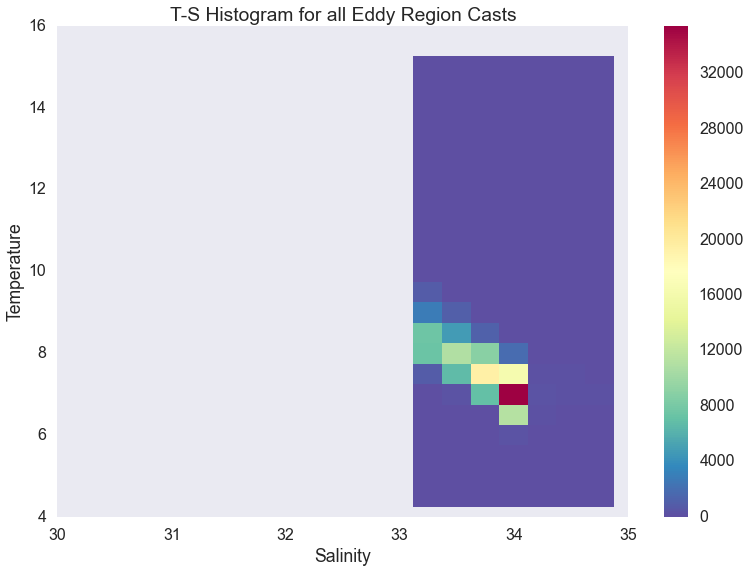

T-S MODE DATA FOR ALL CASTS IN EDDY REGION

Temp. :  6.75737479117
Saln. :  33.8581057173
Dpth. :  134.888958402
sigT. :  27.1772377091


In [252]:
hist,Sval,Tval,TSmode = get_TSmode(ER_cast_inf)

plt.pcolormesh(Sval,Tval,hist.transpose(),cmap='Spectral_r')
plt.colorbar()
plt.xlim((30,35))
plt.ylim((4,16))
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('T-S Histogram for all Eddy Region Casts')
plt.show()

print 'T-S MODE DATA FOR ALL CASTS IN EDDY REGION'
print ''
print 'Temp. : ', TSmode['Temperatur']
print 'Saln. : ', TSmode['Salinity']
print 'Dpth. : ', TSmode['Depth']
print 'sigT. : ', TSmode['sigmaT']

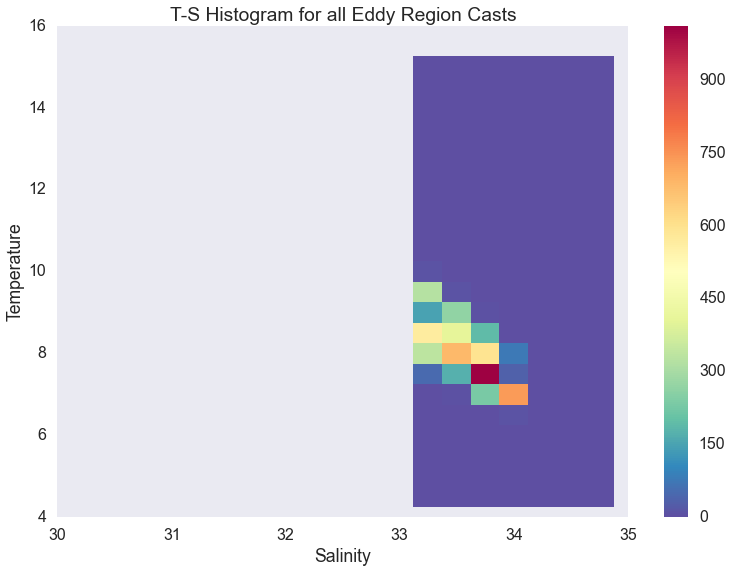

T-S MODE DATA FOR ALL CASTS IN EDDY REGION

Temp. :  7.20637549407
Saln. :  33.6263903162
Dpth. :  91.2580039526
sigT. :  26.730789918


In [253]:
hist,Sval,Tval,TSmode = get_TSmode(csvWOD.filter_year(ER_cast_inf,1992))

plt.pcolormesh(Sval,Tval,hist.transpose(),cmap='Spectral_r')
plt.colorbar()
plt.xlim((30,35))
plt.ylim((4,16))
plt.xlabel('Salinity')
plt.ylabel('Temperature')
plt.title('T-S Histogram for all Eddy Region Casts')
plt.show()

print 'T-S MODE DATA FOR ALL CASTS IN EDDY REGION'
print ''
print 'Temp. : ', TSmode['Temperatur']
print 'Saln. : ', TSmode['Salinity']
print 'Dpth. : ', TSmode['Depth']
print 'sigT. : ', TSmode['sigmaT']

Okay, look at it by individual month now and try to plot out the mode data.

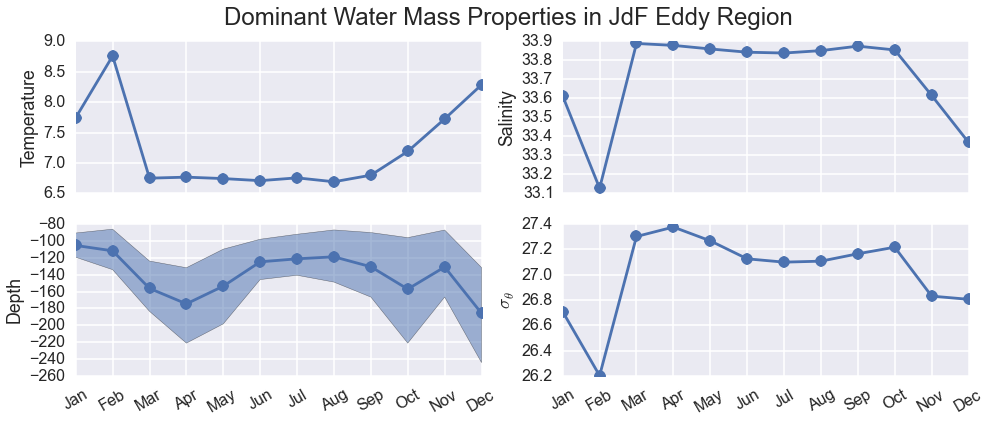

In [254]:
mnth_modes = []

for ii in range(1,13):
    cull_casts = csvWOD.filter_month(ER_cast_inf,ii)
    
    filt2 = []
    # only want to keep the casts that have a reasonable profile depth
    for cast in cull_casts:
        if np.nanmax(cast['Depth']) > 100:
            filt2.append(cast)
    
    hist,Sval,Tval,TSmode = get_TSmode(filt2)
    
    mnth_modes.append(TSmode)

plt.figure(figsize=(16,6))

plt.subplot(2,2,1)
plt.plot(np.arange(1,13),[k['Temperatur'] for k in mnth_modes],'-o')
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
plt.xlim((1,12))
plt.ylabel('Temperature')

plt.subplot(2,2,2)
plt.plot(np.arange(1,13),[k['Salinity'] for k in mnth_modes],'-o')
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
plt.xlim((1,12))
plt.ylabel('Salinity')

plt.subplot(2,2,3)
plt.plot(np.arange(1,13),-np.array([k['Depth'] for k in mnth_modes]),'-o')
plt.fill_between(np.arange(1,13),[-k['MaxDepth'] for k in mnth_modes],[-k['MinDepth'] for k in mnth_modes],alpha=0.5)
plt.xticks(np.arange(1,13), calendar.month_abbr[1:13], rotation=30)
plt.xlim((1,12))
plt.ylabel('Depth')

plt.subplot(2,2,4)
plt.plot(np.arange(1,13),[k['sigmaT'] for k in mnth_modes],'-o')
plt.xticks(np.arange(1,13), calendar.month_abbr[1:13], rotation=30)
plt.xlim((1,12))
plt.ylabel(r'$\sigma_\theta$')

plt.suptitle('Dominant Water Mass Properties in JdF Eddy Region',fontsize=24)
plt.show()

As can be seen from the above plot, during upwelling season the dominant water mass in JdF eddy region changes drastically. During Apr-Sep, the water mass properties are fairly consistent, with mean depth shallowing. Note that the shaded region in the depth image shows the minimum and maximum depths of dominant water mass.

Now let's zoom in on Apr-Sep to investigate the upwelling season behaviour

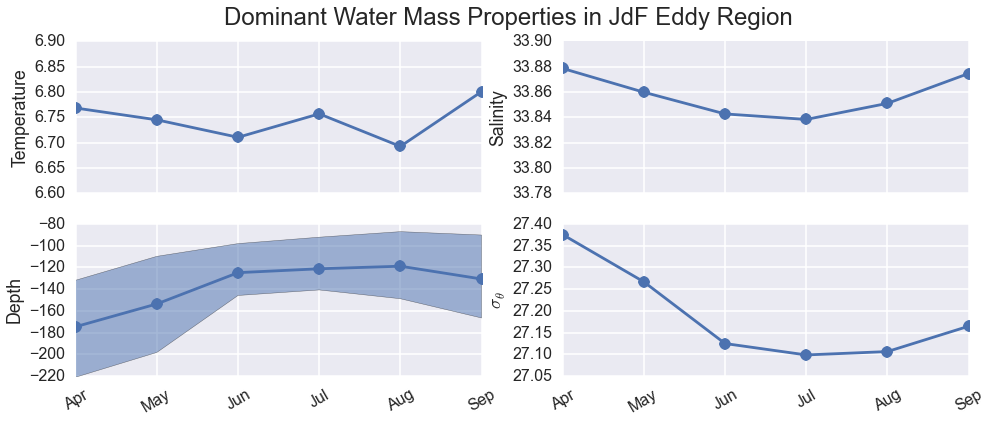

In [261]:
plt.figure(figsize=(16,6))

plt.subplot(2,2,1)
plt.plot(np.arange(4,10),[k['Temperatur'] for k in mnth_modes[3:9]],'-o')
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
plt.xlim((4,9))
plt.ylim((6.6,6.9))
plt.ylabel('Temperature')

plt.subplot(2,2,2)
plt.plot(np.arange(4,10),[k['Salinity'] for k in mnth_modes[3:9]],'-o')
plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
plt.xlim((4,9))
plt.ylim((33.78,33.9))
plt.ylabel('Salinity')

plt.subplot(2,2,3)
plt.plot(np.arange(4,10),-np.array([k['Depth'] for k in mnth_modes[3:9]]),'-o')
plt.fill_between(np.arange(4,10),[-k['MaxDepth'] for k in mnth_modes[3:9]],[-k['MinDepth'] for k in mnth_modes[3:9]],alpha=0.5)
plt.xticks(np.arange(1,13), calendar.month_abbr[1:13], rotation=30)
plt.xlim((4,9))
plt.ylim((-220,-80))
plt.ylabel('Depth')

plt.subplot(2,2,4)
plt.plot(np.arange(4,10),[k['sigmaT'] for k in mnth_modes[3:9]],'-o')
plt.xticks(np.arange(1,13), calendar.month_abbr[1:13], rotation=30)
plt.xlim((4,9))
plt.ylabel(r'$\sigma_\theta$')

plt.suptitle('Dominant Water Mass Properties in JdF Eddy Region',fontsize=24)
plt.show()

Okay, knowing that the water mass properties are relatively consistent between Apr-Sep, let's filter all the data and look at year-wise properties.

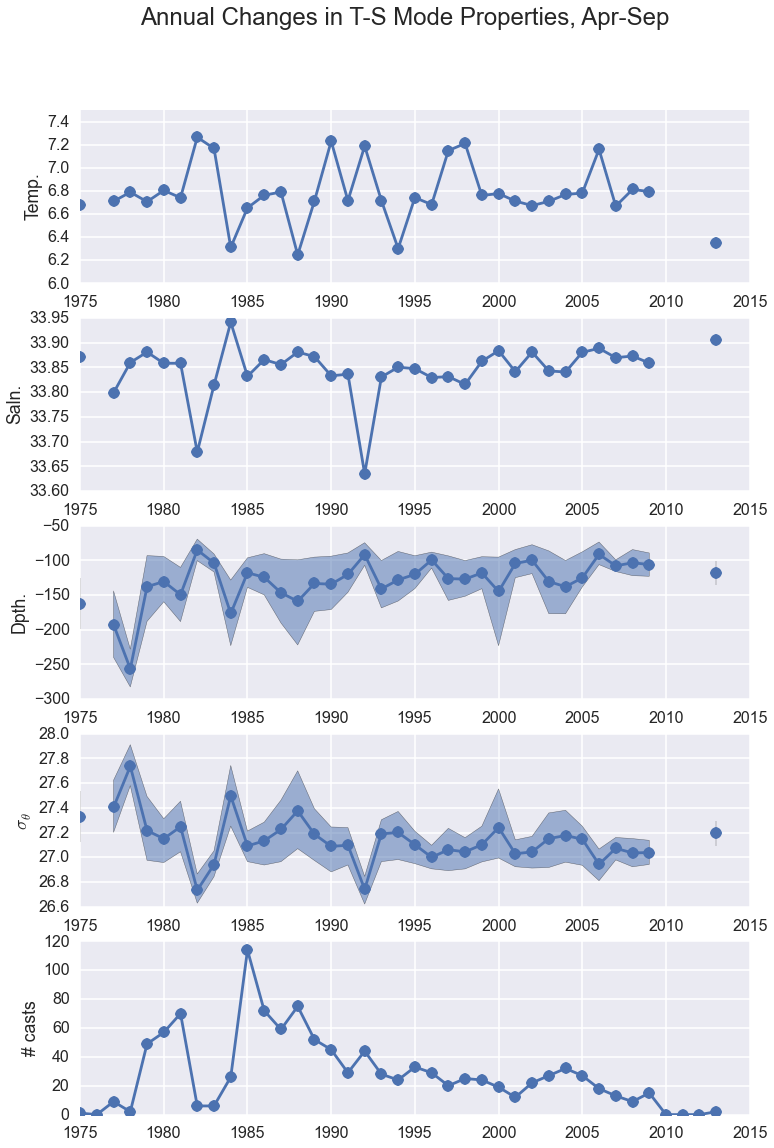

MEAN VALUES OF T-S MODE

 temperature :  6.77923159432  deg C
    salinity :  33.8460322969  psu
       depth :  130.02576144  m
   min depth :  98.6323971503  m
   max depth :  159.594435501  m
   thickness :  60.9620383506  m
      sigmaT :  27.141978182  kg . m^-3
  min sigmaT :  26.9689770603  kg . m^-3
  max sigmaT :  27.3044877411  kg . m^-3


In [256]:
# filter Apr-Sep
yrfilt1 = csvWOD.filter_month(ER_cast_inf,4,9)

MIN_YEAR = 1975
MAX_YEAR = 2013

yr_modes = []
yr_casts = np.zeros(MAX_YEAR-MIN_YEAR+1)

for ii in range(MIN_YEAR,MAX_YEAR+1):
    yrfilt2 = csvWOD.filter_year(yrfilt1,ii)
    yrfilt3 = []

    # only want to keep the casts that have a reasonable profile depth
    for cast in yrfilt2:
        add_cast = False
        if np.nanmax(cast['Depth']) > 100:
            yrfilt3.append(cast)
            yr_casts[ii-MIN_YEAR] += 1
        
    hist,Sval,Tval,TSmode = get_TSmode(yrfilt3)
    
    yr_modes.append(TSmode)
    
plt.figure(figsize=(12,18))
plt.subplot(5,1,1)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[k['Temperatur'] for k in yr_modes],'-o')
#plt.plot([MIN_YEAR,MAX_YEAR],[np.nanmean([k['Temperatur'] for k in yr_modes]),np.nanmean([k['Temperatur'] for k in yr_modes])],'-')
plt.ylabel('Temp.')
plt.ylim((6.,7.5))

plt.subplot(5,1,2)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[k['Salinity'] for k in yr_modes],'-o')
#plt.plot([MIN_YEAR,MAX_YEAR],[np.nanmean([k['Salinity'] for k in yr_modes]),np.nanmean([k['Salinity'] for k in yr_modes])],'-')
plt.ylabel('Saln.')

plt.subplot(5,1,3)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[-k['Depth'] for k in yr_modes],'-o')
plt.fill_between(np.arange(MIN_YEAR,MAX_YEAR+1),[-k['MaxDepth'] for k in yr_modes],[-k['MinDepth'] for k in yr_modes],alpha=0.5)
#plt.plot([MIN_YEAR,MAX_YEAR],[np.nanmean([-k['Depth'] for k in yr_modes]),np.nanmean([-k['Depth'] for k in yr_modes])],'-')
#plt.plot([MIN_YEAR,MAX_YEAR],[np.nanmean([-k['MaxDepth'] for k in yr_modes]),np.nanmean([-k['MaxDepth'] for k in yr_modes])],'-')
#plt.plot([MIN_YEAR,MAX_YEAR],[np.nanmean([-k['MinDepth'] for k in yr_modes]),np.nanmean([-k['MinDepth'] for k in yr_modes])],'-')
plt.ylabel('Dpth.')

plt.subplot(5,1,4)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[k['sigmaT'] for k in yr_modes],'-o')
plt.fill_between(np.arange(MIN_YEAR,MAX_YEAR+1),[k['MaxsigmaT'] for k in yr_modes],[k['MinsigmaT'] for k in yr_modes],alpha=0.5)
#plt.plot([MIN_YEAR,MAX_YEAR],[np.nanmean([k['sigmaT'] for k in yr_modes]),np.nanmean([k['sigmaT'] for k in yr_modes])],'-')
plt.ylabel(r'$\sigma_\theta$')

plt.subplot(5,1,5)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),yr_casts,'-o')
plt.ylabel('# casts')

plt.suptitle('Annual Changes in T-S Mode Properties, Apr-Sep',fontsize=24)
plt.show()

print 'MEAN VALUES OF T-S MODE'
print ''
print ' temperature : ', np.nanmean([k['Temperatur'] for k in yr_modes]), ' deg C'
print '    salinity : ', np.nanmean([k['Salinity'] for k in yr_modes]), ' psu'
print '       depth : ', np.nanmean([k['Depth'] for k in yr_modes]), ' m'
print '   min depth : ', np.nanmean([k['MinDepth'] for k in yr_modes]), ' m'
print '   max depth : ', np.nanmean([k['MaxDepth'] for k in yr_modes]), ' m'
print '   thickness : ', np.nanmean([k['MaxDepth'] for k in yr_modes]) - np.nanmean([k['MinDepth'] for k in yr_modes]), ' m'
print '      sigmaT : ', np.nanmean([k['sigmaT'] for k in yr_modes]), ' kg . m^-3'
print '  min sigmaT : ', np.nanmean([k['MinsigmaT'] for k in yr_modes]), ' kg . m^-3'
print '  max sigmaT : ', np.nanmean([k['MaxsigmaT'] for k in yr_modes]), ' kg . m^-3'

Let's filter out years with fewer than $N$ casts.

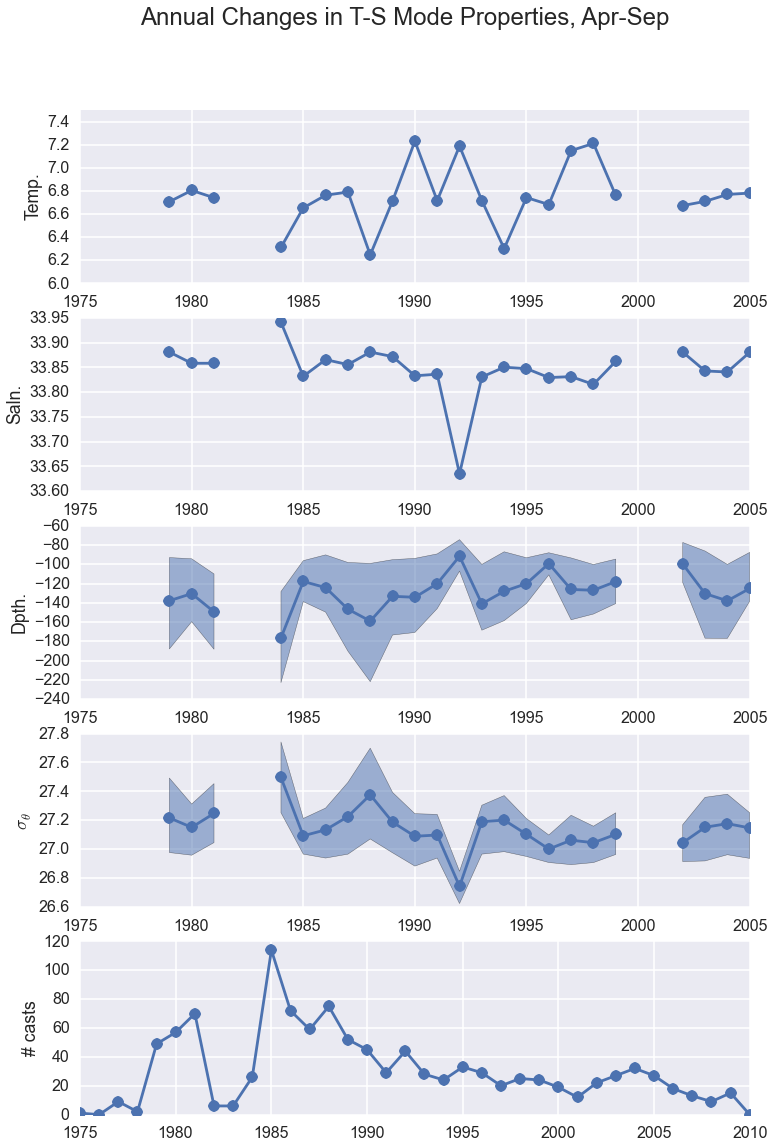

MEAN VALUES OF T-S MODE

 temperature :  6.75552641277  deg C
    salinity :  33.8463380988  psu
       depth :  129.309862199  m
   min depth :  94.3269565217  m
   max depth :  160.76  m
   thickness :  66.4330434783  m
      sigmaT :  27.1421455569  kg . m^-3
  min sigmaT :  26.9511015356  kg . m^-3
  max sigmaT :  27.3117143533  kg . m^-3


In [258]:
MIN_CASTS = 20

yr_modes2 = copy.copy(yr_modes)
for ii in range(0,len(yr_modes2)):
    if yr_casts[ii] < MIN_CASTS:
        yr_modes2[ii]['frac'] = np.nan
        yr_modes2[ii]['Temperatur'] = np.nan
        yr_modes2[ii]['Salinity'] = np.nan
        yr_modes2[ii]['Depth'] = np.nan
        yr_modes2[ii]['MinDepth'] = np.nan
        yr_modes2[ii]['MaxDepth'] = np.nan
        yr_modes2[ii]['sigmaT'] = np.nan
        yr_modes2[ii]['MinsigmaT'] = np.nan
        yr_modes2[ii]['MaxsigmaT'] = np.nan
        
plt.figure(figsize=(12,18))
plt.subplot(5,1,1)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[k['Temperatur'] for k in yr_modes2],'-o')
plt.ylabel('Temp.')
plt.ylim((6.,7.5))

plt.subplot(5,1,2)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[k['Salinity'] for k in yr_modes2],'-o')
plt.ylabel('Saln.')

plt.subplot(5,1,3)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[-k['Depth'] for k in yr_modes2],'-o')
plt.fill_between(np.arange(MIN_YEAR,MAX_YEAR+1),[-k['MaxDepth'] for k in yr_modes2],[-k['MinDepth'] for k in yr_modes2],alpha=0.5)
plt.ylabel('Dpth.')

plt.subplot(5,1,4)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),[k['sigmaT'] for k in yr_modes2],'-o')
plt.fill_between(np.arange(MIN_YEAR,MAX_YEAR+1),[k['MaxsigmaT'] for k in yr_modes2],[k['MinsigmaT'] for k in yr_modes2],alpha=0.5)
plt.ylabel(r'$\sigma_\theta$')

plt.subplot(5,1,5)
plt.plot(np.arange(MIN_YEAR,MAX_YEAR+1),yr_casts,'-o')
plt.ylabel('# casts')
plt.xlim((1975,2010))

plt.suptitle('Annual Changes in T-S Mode Properties, Apr-Sep',fontsize=24)
plt.show()

print 'MEAN VALUES OF T-S MODE'
print ''
print ' temperature : ', np.nanmean([k['Temperatur'] for k in yr_modes2]), ' deg C'
print '    salinity : ', np.nanmean([k['Salinity'] for k in yr_modes2]), ' psu'
print '       depth : ', np.nanmean([k['Depth'] for k in yr_modes2]), ' m'
print '   min depth : ', np.nanmean([k['MinDepth'] for k in yr_modes2]), ' m'
print '   max depth : ', np.nanmean([k['MaxDepth'] for k in yr_modes2]), ' m'
print '   thickness : ', np.nanmean([k['MaxDepth'] for k in yr_modes2]) - np.nanmean([k['MinDepth'] for k in yr_modes2]), ' m'
print '      sigmaT : ', np.nanmean([k['sigmaT'] for k in yr_modes2]), ' kg . m^-3'
print '  min sigmaT : ', np.nanmean([k['MinsigmaT'] for k in yr_modes2]), ' kg . m^-3'
print '  max sigmaT : ', np.nanmean([k['MaxsigmaT'] for k in yr_modes2]), ' kg . m^-3'